In [103]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import json
import numpy as np
from pdf2image import convert_from_path
from operator import itemgetter

In [104]:
SCITSR_PATH = '/Users/longhoang/Developer/table-reg/data/SciTSR'
SCITSR_TRAIN = os.path.join(SCITSR_PATH, 'train')
SCITSR_TEST = os.path.join(SCITSR_PATH, 'test')

In [105]:
TRAIN_IMG_DIR = os.path.join(SCITSR_TRAIN, 'img')
imgs_paths = [os.path.join(TRAIN_IMG_DIR, p) for p in os.listdir(TRAIN_IMG_DIR)]
len(imgs_paths)

12000

In [106]:
# valid_imgs_paths = [p for p in imgs_paths if cv.imread(p) is not None]
# len(valid_imgs_paths)

(220, 966, 3) /Users/longhoang/Developer/table-reg/data/SciTSR/train/img/1101.3448v1.2.png


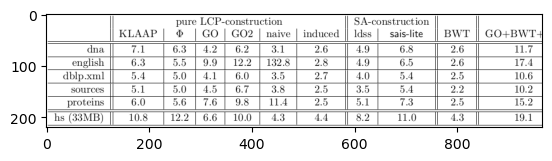

In [107]:
IX = 19

def load_image(img_path):
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

# img_path = valid_imgs_paths[IX]
img_path = '/Users/longhoang/Developer/table-reg/data/SciTSR/train/img/1101.3448v1.2.png'
img = load_image(img_path)
plt.imshow(img)
print(img.shape, img_path)

In [108]:
def path2name(img_path):
    return os.path.splitext(os.path.basename(img_path))[0]

img_name = path2name(img_path)
img_name

'1101.3448v1.2'

In [109]:
def read_struct(struct_path):
    cell_list = []
    n_rows, n_cols = 0, 0
    with open(struct_path) as f:
        data = json.load(f)
        cells = data['cells']
        for c in cells:
            content = c['content']
            if len(content) == 0: continue
            id = c['id']
            sr, er = c['start_row'], c['end_row']
            sc, ec = c['start_col'], c['end_col']
            n_rows = max(n_rows, er+1)
            n_cols = max(n_cols, ec+1)
            cell_list.append({
                'id': id,
                'range': [sr, er, sc, ec],
                'content': content
            })
    cell_list = sorted(cell_list, key=itemgetter('id'))
    return cell_list, n_rows, n_cols


TRAIN_STRUCT_DIR = os.path.join(SCITSR_TRAIN, 'structure')
img_struct_path = img_path.replace('png', 'json').replace('img', 'structure')
cells, nrows, ncols = read_struct(img_struct_path)

In [110]:
print(img_struct_path)

/Users/longhoang/Developer/table-reg/data/SciTSR/train/structure/1101.3448v1.2.json


In [111]:
cells

[{'id': 1, 'range': [0, 0, 1, 6], 'content': ['pure', 'LCP-construction']},
 {'id': 2, 'range': [0, 0, 7, 8], 'content': ['SA-construction']},
 {'id': 4, 'range': [0, 0, 10, 12], 'content': ['SA+LCP']},
 {'id': 6, 'range': [1, 1, 1, 1], 'content': ['KLAAP']},
 {'id': 7, 'range': [1, 1, 2, 2], 'content': ['Φ']},
 {'id': 8, 'range': [1, 1, 3, 3], 'content': ['GO']},
 {'id': 9, 'range': [1, 1, 4, 4], 'content': ['GO2']},
 {'id': 10, 'range': [1, 1, 5, 5], 'content': ['naive']},
 {'id': 11, 'range': [1, 1, 6, 6], 'content': ['induced']},
 {'id': 12, 'range': [1, 1, 7, 7], 'content': ['ldss']},
 {'id': 13, 'range': [1, 1, 8, 8], 'content': ['sais-lite']},
 {'id': 14, 'range': [1, 1, 9, 9], 'content': ['BWT']},
 {'id': 15, 'range': [1, 1, 10, 10], 'content': ['GO+BWT+ldss']},
 {'id': 16, 'range': [1, 1, 11, 11], 'content': ['naive', '+', 'ldss']},
 {'id': 17, 'range': [1, 1, 12, 12], 'content': ['ind', '+', 'sais-lite']},
 {'id': 18, 'range': [2, 2, 0, 0], 'content': ['dna']},
 {'id': 19, 'r

In [112]:
nrows, ncols

(8, 13)

In [113]:
# TRAIN_REL_DIR = os.path.join(SCITSR_TRAIN, 'rel')
# img_rel_path = img_path.replace('png', 'rel').replace('img', 'rel')

In [114]:
def create_label(cells, nrows, ncols, img_path=None):
    D = np.zeros((nrows-1, ncols), dtype=np.uint8) # (down) matrix of merging rows
    R = np.zeros((nrows, ncols-1), dtype=np.uint8) # (right) matrix of merging columns
    for c in cells:
        sr, er, sc, ec = c['range']
        if sr > er or sc > ec:
            print(f"Cell number {c['id']} has invalid rows or columns: {sr, er, sc, ec}")
            if img_path: 
                print("  Image path:", img_path)
            continue
        if sr < er and sc == ec:
            D[sr:er, sc] = 1
        if sr == er and sc < ec:
            R[sr, sc:ec] = 1
        if sr < er and sc < ec:
            print(f"Cell number {c['id']} spans both rows and columns")
    return D, R

D, R = create_label(cells, nrows, ncols)

In [115]:
D, D.shape

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8),
 (7, 13))

In [116]:
R, R.shape

(array([[0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8),
 (8, 12))

In [117]:
# load back split labels
SPLIT_LABEL_PATH = '/Users/longhoang/Developer/table-reg/data/SciTSR/train/label/split_label.json'
with open(SPLIT_LABEL_PATH, 'r') as f:
    split_labels = json.load(f)

len(split_labels)

11971

In [118]:
LABELS = {}
LABELS[img_name] = {
    'rows': split_labels[img_name]['rows'],
    'columns': split_labels[img_name]['columns'],
    'h_matrix': R.tolist(),
    'v_matrix': D.tolist()
}

In [119]:
TRAIN_LABEL_PATH = os.path.join(SCITSR_TRAIN, 'label')
os.makedirs(TRAIN_LABEL_PATH, exist_ok=True)

# with open(os.path.join(TRAIN_LABEL_PATH, 'merge_label.json'), 'w') as f:
#     json.dump(LABELS, f)

In [120]:
# test correctness
MERGE_LABEL_PATH = os.path.join(TRAIN_LABEL_PATH, 'merge_label.json')
with open(MERGE_LABEL_PATH, 'r') as f:
    data = json.load(f)

data = data[img_name]
len(data['rows']), len(data['columns']), np.array(data['h_matrix']).shape, np.array(data['v_matrix']).shape

(220, 966, (8, 12), (7, 13))

Putting everything together

In [121]:
def view_imgs(imgs):
    fig = plt.figure(figsize=(7,7))
    for i, img in enumerate(imgs):
        plt.subplot(1, len(imgs), i+1)
        if img.ndim == 3:
            if img.shape[-1] == 3:
                plt.imshow(img)
            else:
                plt.imshow(img[..., 0], cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()

In [122]:
def prepare_merge_labels(folder_path: str, json_path: str, split_label_path: str):
    '''
    Params:
        folder_path -- string, path to image folder either train or test folder
        json_path -- string, path to json file to write ground truth into
        split_label_path -- string, path to the json file 
                            which stores ground truths for split module
    Returns:
        None
    '''
    # load split labels
    with open(split_label_path, 'r') as f:
        split_labels = json.load(f)
    print(f"Loaded {len(split_labels)} labels for Split module")

    imgs_paths = [os.path.join(folder_path, p) for p in os.listdir(folder_path)]
    valid_imgs_paths = [p for p in imgs_paths if cv.imread(p) is not None]
    print(f"Found {len(valid_imgs_paths)} image paths out of {len(imgs_paths)} paths")

    LABELS = {}
    for i, img_path in enumerate(valid_imgs_paths):
        img = load_image(img_path)
        # view_imgs([img])
        img_name = path2name(img_path)
        # read structure file to get cell locations
        img_struct_path = img_path.replace('png', 'json').replace('img', 'structure')
        cells, nrows, ncols = read_struct(img_struct_path)
        D, R = create_label(cells, nrows, ncols, img_path)
        LABELS[img_name] = {
            'rows': split_labels[img_name]['rows'],
            'columns': split_labels[img_name]['columns'],
            'h_matrix': R.tolist(),
            'v_matrix': D.tolist()
        }
        if (i + 1) % 100 == 0:
            print(f"Got labels for {i+1} images!")
    
    with open(json_path, 'w') as f:
        json.dump(LABELS, f)
    return None

In [123]:
prepare_merge_labels(TRAIN_IMG_DIR, MERGE_LABEL_PATH, SPLIT_LABEL_PATH)

Loaded 11971 labels for Split module


libpng error: Read Error
libpng error: Read Error
libpng error: Read Error
libpng error: Read Error
libpng error: Read Error
libpng error: Read Error


Found 11971 image paths out of 12000 paths
Got labels for 100 images!
Got labels for 200 images!
Got labels for 300 images!
Got labels for 400 images!
Got labels for 500 images!
Got labels for 600 images!
Got labels for 700 images!
Got labels for 800 images!
Got labels for 900 images!
Got labels for 1000 images!
Got labels for 1100 images!
Got labels for 1200 images!
Got labels for 1300 images!
Got labels for 1400 images!
Got labels for 1500 images!
Got labels for 1600 images!
Got labels for 1700 images!
Got labels for 1800 images!
Got labels for 1900 images!
Got labels for 2000 images!
Got labels for 2100 images!
Got labels for 2200 images!
Got labels for 2300 images!
Got labels for 2400 images!
Got labels for 2500 images!
Got labels for 2600 images!
Got labels for 2700 images!
Got labels for 2800 images!
Got labels for 2900 images!
Got labels for 3000 images!
Got labels for 3100 images!
Got labels for 3200 images!
Got labels for 3300 images!
Got labels for 3400 images!
Got labels for

In [124]:
with open(MERGE_LABEL_PATH, 'r') as f:
    merge_labels = json.load(f)
len(merge_labels)

11971